In [1]:
import numpy as np
import pandas as pd
import cvxpy as cp
import matplotlib.pyplot as plt

In [2]:
# ---------- Helper Functions: box uncertainty set & weighting factor ----------

# 1. Construct the box-shaped uncertainty set Ξ (axis-aligned hyper-rectangle)
def build_box_uncertainty(Z_all, qmin=0.01, qmax=0.99, eta=0.02):
    """return [ell, upp] in each dimension of Z_all"""
    low  = np.quantile(Z_all, qmin, axis=0)
    high = np.quantile(Z_all, qmax, axis=0)
    span = high - low
    ell  = low  - eta * span
    upp  = high + eta * span
    # Avoid zero-width intervals
    upp = np.maximum(upp, ell + 1e-10)
    return ell, upp

def build_box_conic_from_bounds(ell, upp, n):
    """
    Rewrite the box uncertainty set  Ξ = { (x,y): ell <= (x,y) <= upp }
    into the form C1 x + c2 y <= d   (C is the nonnegative orthant cone), for direct use of Corollary 3.3.
    Return C1 (m*n), c2 (m,), d (m,), where m = 2*(n+1)
    where n = dim(x), y is a scalar
    """
    m = 2*(n+1)
    C1 = np.zeros((m, n))
    c2 = np.zeros(m)
    d  = np.zeros(m)

    row = 0
    # upper bound： x_j <= upp_j
    for j in range(n):
        C1[row, j] = 1.0
        d[row] = upp[j]
        row += 1
    # lower bound： -x_j <= -ell_j
    for j in range(n):
        C1[row, j] = -1.0
        d[row] = -ell[j]
        row += 1
    # upper bound for y： y <= upp_y
    c2[row] = 1.0
    d[row] = upp[n]
    row += 1
    # lower bound for y： -y <= -ell_y
    c2[row] = -1.0
    d[row] = -ell[n]
    row += 1

    assert row == m
    return C1, c2, d

# 2a. Compute time-dependent sample weights (exponential forgetting)
def time_weights_from_indices(time_idx, now_t, decay):
    raw = decay ** (now_t - time_idx)
    pi = raw / raw.sum()
    return pi

# 2b. Optimal weights according to Proposition 2 (for p = 1)
def optimal_weights_prop2(T, eps_over_rho):
    """
    Proposition 2 optimal weights for p = 1:
    - T = history length
    - eps_over_rho = ε/ρ in the paper, where eps in our code is ambuiguity radius, rho is the wasserstein distance between Pt and Pt+1
    Return weights w of length T
    """

    # s = floor(eps / rho)
    s = int(np.floor(eps_over_rho))
    s = max(1, min(s, T))  # truncate to [1, T]
    
    w = np.zeros(T)
    denom = s * (2 * eps_over_rho - s - 1)
    
    for t in range(T - s, T):
        # t runs from T-s to T-1  (0-index)
        w[t] = 2 * ((eps_over_rho) + (t+1) - T - 1) / denom

    return w

# 3. DRO ε-insensitive SVR
# ---------- Core：DRO-SVR following Corollary 3.3 ----------
def solve_dro_svr_cor33(X, y, C1, c2, d, pi, epsilon=1.0, rho=0.5, use_mosek=True):
    """
    Corollary 3.3 (Support Vector Regression):
      min   λ ρ + sum_i π_i s_i
      s.t.  y_i - <w,x_i> - ε + <p_i^+, d - C1 x_i - c2 y_i> <= s_i
            <w,x_i> - y_i - ε + <p_i^-, d - C1 x_i - c2 y_i> <= s_i
            || ( C1^T p_i^+ + w ,  c2^T p_i^+ - 1 ) ||_* <= λ
            || ( C1^T p_i^- - w ,  c2^T p_i^- + 1 ) ||_* <= λ
            p_i^+, p_i^- >= 0,  s_i >= 0
    """
    N, n = X.shape
    m = C1.shape[0]  # number of constraints (2*(n+1))

    w   = cp.Variable(n)
    lam = cp.Variable(nonneg=True)
    s   = cp.Variable(N, nonneg=True)

    constraints = []

    # pre-calculate (d - C1 x_i - c2 y_i) for each sample
    D_minus_Axi_cy = (d[None, :] - X @ C1.T - np.outer(y, c2))  # (N,m)

    for i in range(N):
        p_plus_i  = cp.Variable(m, nonneg=True)
        p_minus_i = cp.Variable(m, nonneg=True)

        # y_i - <w,x_i> - ε + <p_i^+, ...> <= s_i
        lhs1_i = (y[i] - X[i] @ w - epsilon + p_plus_i @ D_minus_Axi_cy[i, :])
        constraints += [lhs1_i <= s[i]]

        # <w,x_i> - y_i - ε + <p_i^-, ...> <= s_i
        lhs2_i = (X[i] @ w - y[i] - epsilon + p_minus_i @ D_minus_Axi_cy[i, :])
        constraints += [lhs2_i <= s[i]]

        # || ( C1^T p_i^+ + w ,  c2^T p_i^+ - 1 ) ||_2 <= λ
        # || ( C1^T p_i^- - w ,  c2^T p_i^- + 1 ) ||_2 <= λ
        vec_minus = cp.hstack([C1.T @ p_minus_i - w,  c2 @ p_minus_i + 1.0])
        vec_plus = cp.hstack([C1.T @ p_plus_i + w,  c2 @ p_plus_i - 1.0])

        constraints += [
            cp.norm(vec_plus,  'inf') <= lam,
            cp.norm(vec_minus, 'inf') <= lam
        ]

    # objective：λ ρ + sum_i π_i s_i
    pi_param = cp.Parameter(N, nonneg=True, value=np.asarray(pi, float))
    obj = cp.Minimize(lam * rho + pi_param @ s)

    prob = cp.Problem(obj, constraints)
    try:
        prob.solve(solver=cp.MOSEK if use_mosek else cp.ECOS, verbose=False)
    except cp.SolverError:
        prob.solve(solver=cp.ECOS, verbose=False)

    return w.value, prob.status

# 4. Empirical ε-insensitive SVR (no regularization, time-weighted)
def solve_empirical_svr_noreg(X, y, epsilon=1.0, sample_weights=None, use_mosek=True):
    N, n = X.shape
    w = cp.Variable(n)
    resid = y - X @ w
    loss  = cp.pos(cp.abs(resid) - epsilon)  # max(0, |r|-ε)

    if sample_weights is None:
        obj = cp.Minimize(cp.sum(loss) / N)
    else:
        sw = cp.Parameter(N, nonneg=True, value=np.asarray(sample_weights, float))
        weighted_loss = cp.sum(cp.multiply(sw, loss))
        obj = cp.Minimize(weighted_loss)

    prob = cp.Problem(obj)
    try:
        prob.solve(solver=cp.MOSEK if use_mosek else cp.ECOS, verbose=False)
    except cp.SolverError:
        prob.solve(solver=cp.ECOS, verbose=False)
    return w.value, prob.status

# 5. ε-insensitive loss
def eps_ins_loss(y_true, y_pred, eps):
    return np.maximum(0, np.abs(y_true - y_pred) - eps)

In [3]:
df = pd.read_csv("historic_demand_2009_2024_noNaN.csv")
df

,settlement_date,settlement_period,period_hour,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,is_holiday
0,2009/1/1 0:00,1,0:00:00,37910,38704,33939,54,1403,0,0,0,33,2002,0,0,-161,0,0,1
1,2009/1/1 0:30,2,0:30:00,38047,38964,34072,53,1403,0,0,0,157,2002,0,0,-160,0,0,1
2,2009/1/1 1:00,3,1:00:00,37380,38651,33615,53,1403,0,0,0,511,2002,0,0,-160,0,0,1
3,2009/1/1 1:30,4,1:30:00,36426,37775,32526,50,1403,0,0,0,589,1772,0,0,-160,0,0,1
4,2009/1/1 2:00,5,2:00:00,35687,37298,31877,50,1403,0,0,0,851,1753,0,0,-160,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278507,2024/12/5 21:30,44,21:30:00,29114,31431,27212,5377,6622,0,17194,0,736,558,758,1003,-450,-531,999,0
278508,2024/12/5 22:00,45,22:00:00,27204,29846,25477,5486,6622,0,17194,0,868,-193,263,1002,-450,-531,949,0
278509,2024/12/5 22:30,46,22:30:00,26006,28805,24428,5594,6622,0,17194,0,944,-274,211,997,-450,-531,943,0
278510,2024/12/5 23:00,47,23:00:00,23908,26825,22590,5575,6622,0,17194,0,864,-404,-77,280,-450,-522,338,0


In [4]:
df['datetime'] = pd.to_datetime(df['settlement_date'] + ' ' + df['period_hour'])
df = df.set_index('datetime').sort_index()
df = df.loc[:'2024-11-30']
df

C:\Users\11864\AppData\Local\Temp\ipykernel_10036\1515799140.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['datetime'] = pd.to_datetime(df['settlement_date'] + ' ' + df['period_hour'])


,settlement_date,settlement_period,period_hour,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,is_holiday
datetime,,,,,,,,,,,,,,,,,,,
2009-01-01 00:00:00,2009/1/1 0:00,1,0:00:00,37910,38704,33939,54,1403,0,0,0,33,2002,0,0,-161,0,0,1
2009-01-01 00:30:00,2009/1/1 0:30,2,0:30:00,38047,38964,34072,53,1403,0,0,0,157,2002,0,0,-160,0,0,1
2009-01-01 01:00:00,2009/1/1 1:00,3,1:00:00,37380,38651,33615,53,1403,0,0,0,511,2002,0,0,-160,0,0,1
2009-01-01 01:30:00,2009/1/1 1:30,4,1:30:00,36426,37775,32526,50,1403,0,0,0,589,1772,0,0,-160,0,0,1
2009-01-01 02:00:00,2009/1/1 2:00,5,2:00:00,35687,37298,31877,50,1403,0,0,0,851,1753,0,0,-160,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-30 21:30:00,2024/11/30 21:30,44,21:30:00,26481,27371,25166,4712,6622,0,17194,0,12,291,9,339,400,0,-278,0
2024-11-30 22:00:00,2024/11/30 22:00,45,22:00:00,25167,26382,23918,4759,6622,0,17194,0,15,122,-19,-136,400,0,-445,0
2024-11-30 22:30:00,2024/11/30 22:30,46,22:30:00,24094,25407,22899,4805,6622,0,17194,0,68,106,-28,-160,399,0,-457,0


In [5]:
y_monthly = df['nd'].resample('ME').sum()
y_monthly

datetime
2009-01-31    63238939
2009-02-28    56073378
2009-03-31    56519297
2009-04-30    49311414
2009-05-31    48437067
                ...   
2024-07-31    33960607
2024-08-31    32288427
2024-09-30    35002964
2024-10-31    39733798
2024-11-30    44037304
Freq: ME, Name: nd, Length: 191, dtype: int64

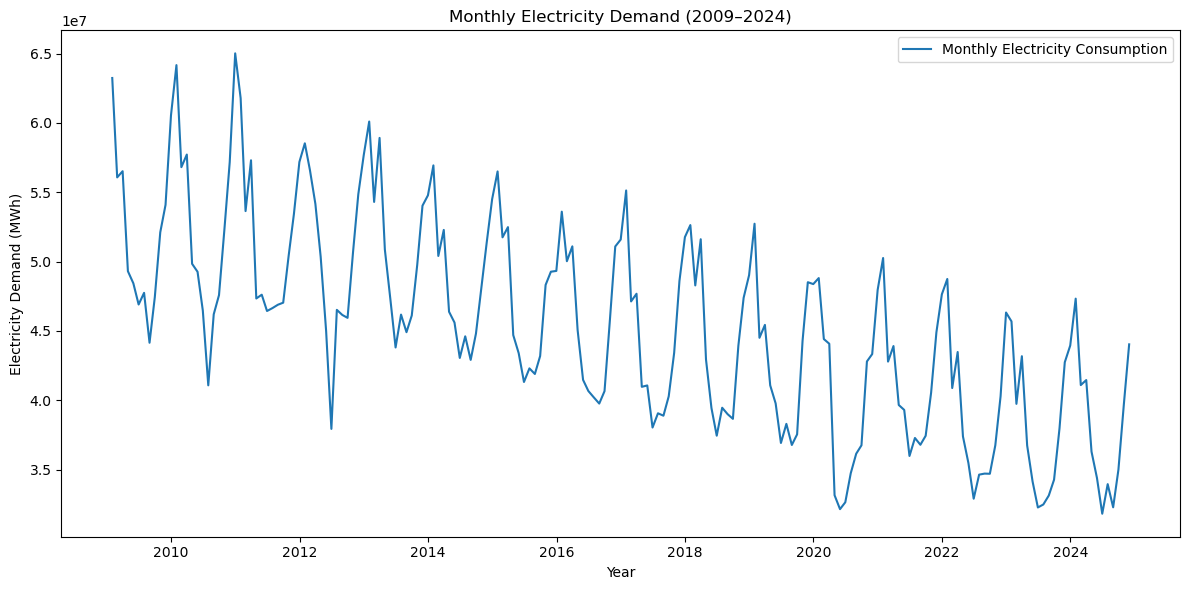

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(y_monthly, label="Monthly Electricity Consumption")
plt.xlabel("Year")
plt.ylabel("Electricity Demand (MWh)")
plt.title("Monthly Electricity Demand (2009–2024)")
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
X_monthly = pd.DataFrame(index=y_monthly.index)
X_monthly['wind_gen'] = (df['embedded_wind_generation'].resample('ME').sum())
X_monthly['solar_gen'] = (df['embedded_solar_generation'].resample('ME').sum())
X_monthly['pump'] = (df['pump_storage_pumping'].resample('ME').sum())
X_monthly['holiday_ratio'] = (df['is_holiday'].resample('ME').mean())

assert X_monthly.index.equals(y_monthly.index)
print(X_monthly.shape, y_monthly.shape)
X_monthly

(191, 4) (191,)


,wind_gen,solar_gen,pump,holiday_ratio
datetime,,,,
2009-01-31,884444,0,641445,0.032258
2009-02-28,605475,0,661261,0.000000
2009-03-31,1006838,0,658593,0.000000
2009-04-30,661797,0,355152,0.066667
2009-05-31,1096316,0,554994,0.064516
...,...,...,...,...
2024-07-31,1784606,3700735,189010,0.000000
2024-08-31,3096671,3447975,305677,0.032258
2024-09-30,2265450,2328705,188524,0.000000


In [8]:
def add_pure_correlation_drift(X, y, time_index, feature_id, strength=0.2):
    t = (time_index - time_index.min()) / (time_index.max() - time_index.min())

    y_mean = y.mean()
    y_std  = y.std()
    y_norm = (y - y_mean) / y_std

    x_feat = X[:, feature_id]
    x_norm = (x_feat - x_feat.mean()) / x_feat.std()

    drift_term = strength * t * x_norm

    y_new = y_norm + drift_term
    return y_new * y_std + y_mean

X_vals = X_monthly.values
y_orig = y_monthly.values.copy()

time_index = np.arange(len(y_orig))

X = X_vals
y_base = y_orig.copy()


=== Time ratio 0.6 ===
Train+Val samples: 114
Test samples     : 77
  Train samples: 91
  Val   samples: 23
  [SAA]   val eps-loss: 684380.7928206098
  [W-SAA] best val eps-loss: 387550.90860853245 | best decay = 0.65
  [WDRO]  best val eps-loss: 298759.255997408 | best decay = 0.85 | best rho = 0.00035938136638046257
  [Prop2] best val eps-loss: 255139.49852415337 | best rho = 0.00035938136638046257 | best eps/rho = 19.080000000000002
>> [SAA]   test eps-loss: 19922583.235867307
>> [W-SAA] test eps-loss: 12685397.378765753
>> [WDRO]  test eps-loss: 13832661.37619805
>> [Prop2] test eps-loss: 12066704.14274881

=== Time ratio 0.7 ===
Train+Val samples: 133
Test samples     : 58
  Train samples: 106
  Val   samples: 27
  [SAA]   val eps-loss: 7397197.252723093
  [W-SAA] best val eps-loss: 3402890.623163568 | best decay = 0.65
  [WDRO]  best val eps-loss: 2626702.561868151 | best decay = 0.65 | best rho = 10.0
  [Prop2] best val eps-loss: 2626702.554655516 | best rho = 0.016681005372000

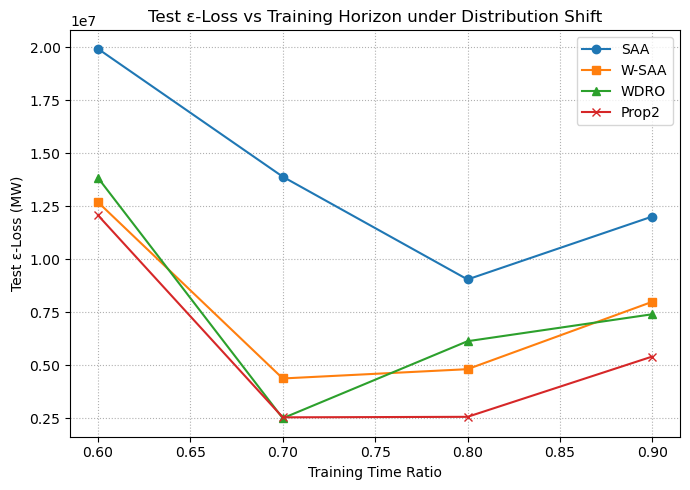

In [9]:
T_total = len(y_base)

epsilon = 0.5e7
time_ratios = [0.6, 0.7, 0.8, 0.9]
rho_list    = np.logspace(-4, 1, 10)
decay_list  = [0.65, 0.75, 0.85, 0.95]

results = {
    "ratio": [],
    "SAA": [],
    "W-SAA": [],
    "WDRO": [],
    "Prop2": []
}

# ================================
# Main loop over training ratios
# ================================
for ratio in time_ratios:

    print(f"\n=== Time ratio {ratio:.1f} ===")

    # ------------------------------------------------
    # 1. Outer split: Train+Val / Test (by time order)
    # ------------------------------------------------
    T_cut = int(ratio * T_total)

    X_trainval = X[:T_cut]
    X_test     = X[T_cut:]

    # ------------------------------------------------
    # STEP + TREND drift (same style as housing version)
    # y = y_base + (strength(time) * t) * x_feature_norm  (in normalized space)
    # ------------------------------------------------
    feature_id = 0           # 0=wind, 1=solar, 2=pump
    strength_train = 1.5
    strength_test  = 3.0

    T_total = len(y_base)
    time_index = np.arange(T_total, dtype=float)
    t_all = (time_index - time_index.min()) / (time_index.max() - time_index.min() + 1e-12)

    # fixed stats from BASE (avoid extra shift/leakage)
    y_mean = y_base.mean()
    y_std  = y_base.std() + 1e-12
    y_norm = (y_base - y_mean) / y_std

    xj = X[:, feature_id]
    xj_mean = xj.mean()
    xj_std  = xj.std() + 1e-12
    xj_norm = (xj - xj_mean) / xj_std

    # step strength vector: depends on THIS ratio's cut
    strength_vec = np.empty(T_total, dtype=float)
    strength_vec[:T_cut] = strength_train
    strength_vec[T_cut:] = strength_test

    # drifted y on full horizon, then split
    y_all = (y_norm + (strength_vec * t_all) * xj_norm) * y_std + y_mean

    y_trainval = y_all[:T_cut]
    y_test     = y_all[T_cut:]

    print("Train+Val samples:", X_trainval.shape[0])
    print("Test samples     :", X_test.shape[0])

    # ------------------------------------------------
    # 2. Inner split: Train / Val
    # ------------------------------------------------
    inner_ratio = 0.8
    n_train = int(inner_ratio * T_cut)

    X_train = X_trainval[:n_train]
    y_train = y_trainval[:n_train]

    X_val = X_trainval[n_train:]
    y_val = y_trainval[n_train:]

    print("  Train samples:", X_train.shape[0])
    print("  Val   samples:", X_val.shape[0])

    T_time = len(y_train)

    # ------------------------------------------------
    # 3. Build Box uncertainty set (TRAIN only)
    # ------------------------------------------------
    Z_train = np.hstack([X_train, y_train[:, None]])
    ell, upp = build_box_uncertainty(Z_train, qmin=0.01, qmax=0.99, eta=0.02)
    C1, c2, d = build_box_conic_from_bounds(ell, upp, X_train.shape[1])

    # ============================================================
    # 4. SAA
    # ============================================================
    w_saa, _ = solve_empirical_svr_noreg(
        X_train, y_train, epsilon=epsilon
    )
    val_loss_saa = eps_ins_loss(y_val, X_val @ w_saa, epsilon).mean()
    print("  [SAA]   val eps-loss:", val_loss_saa)

    # ============================================================
    # 5. W-SAA (tune decay)
    # ============================================================
    best_wsaa_loss = np.inf
    best_wsaa_decay = None

    for decay in decay_list:
        pi = time_weights_from_indices(
            np.arange(T_time),
            now_t=T_time - 1,
            decay=decay
        )

        w_wsaa, _ = solve_empirical_svr_noreg(
            X_train, y_train,
            epsilon=epsilon,
            sample_weights=pi
        )

        val_loss = eps_ins_loss(y_val, X_val @ w_wsaa, epsilon).mean()

        if val_loss < best_wsaa_loss:
            best_wsaa_loss = val_loss
            best_wsaa_decay = decay

    print("  [W-SAA] best val eps-loss:", best_wsaa_loss,
          "| best decay =", best_wsaa_decay)

    # ============================================================
    # 6. WDRO (tune decay + rho)
    # ============================================================
    best_wdro_loss = np.inf
    best_wdro_decay = None
    best_wdro_rho = None

    for decay in decay_list:
        pi = time_weights_from_indices(
            np.arange(T_time),
            now_t=T_time - 1,
            decay=decay
        )

        for rho in rho_list:
            w_wdro, _ = solve_dro_svr_cor33(
                X_train, y_train,
                C1, c2, d,
                pi,
                epsilon=epsilon,
                rho=rho
            )

            val_loss = eps_ins_loss(y_val, X_val @ w_wdro, epsilon).mean()

            if val_loss < best_wdro_loss:
                best_wdro_loss = val_loss
                best_wdro_decay = decay
                best_wdro_rho = rho

    print("  [WDRO]  best val eps-loss:", best_wdro_loss,
          "| best decay =", best_wdro_decay,
          "| best rho =", best_wdro_rho)

    # ============================================================
    # 7. Prop2-DRO
    # ============================================================
    eps_over_rho_list = np.linspace(1.1, T_time, 6)

    best_prop2_loss = np.inf
    best_prop2_rho = None
    best_prop2_epsrho = None

    for rho in rho_list:
        for eps_over_rho in eps_over_rho_list:

            pi = optimal_weights_prop2(T_time, eps_over_rho)
            pi = pi / pi.sum()

            w_prop2, _ = solve_dro_svr_cor33(
                X_train, y_train,
                C1, c2, d,
                pi,
                epsilon=epsilon,
                rho=rho
            )

            val_loss = eps_ins_loss(y_val, X_val @ w_prop2, epsilon).mean()

            if val_loss < best_prop2_loss:
                best_prop2_loss = val_loss
                best_prop2_rho = rho
                best_prop2_epsrho = eps_over_rho

    print("  [Prop2] best val eps-loss:", best_prop2_loss,
          "| best rho =", best_prop2_rho,
          "| best eps/rho =", best_prop2_epsrho)

    # ============================================================
    # 8. Final retraining on Train+Val → Test
    # ============================================================

    # ---- SAA ----
    w_saa_final, _ = solve_empirical_svr_noreg(
        X_trainval, y_trainval, epsilon=epsilon
    )
    test_loss_saa = eps_ins_loss(
        y_test, X_test @ w_saa_final, epsilon
    ).mean()

    # ---- W-SAA ----
    pi_wsaa_full = time_weights_from_indices(
        np.arange(len(y_trainval)),
        now_t=len(y_trainval) - 1,
        decay=best_wsaa_decay
    )

    w_wsaa_final, _ = solve_empirical_svr_noreg(
        X_trainval, y_trainval,
        epsilon=epsilon,
        sample_weights=pi_wsaa_full
    )
    test_loss_wsaa = eps_ins_loss(
        y_test, X_test @ w_wsaa_final, epsilon
    ).mean()

    # ---- WDRO ----
    pi_wdro_full = time_weights_from_indices(
        np.arange(len(y_trainval)),
        now_t=len(y_trainval) - 1,
        decay=best_wdro_decay
    )

    w_wdro_final, _ = solve_dro_svr_cor33(
        X_trainval, y_trainval,
        C1, c2, d,
        pi_wdro_full,
        epsilon=epsilon,
        rho=best_wdro_rho
    )
    test_loss_wdro = eps_ins_loss(
        y_test, X_test @ w_wdro_final, epsilon
    ).mean()

    # ---- Prop2 ----
    pi_prop2_full = optimal_weights_prop2(
        len(y_trainval),
        best_prop2_epsrho
    )
    pi_prop2_full = pi_prop2_full / pi_prop2_full.sum()

    w_prop2_final, _ = solve_dro_svr_cor33(
        X_trainval, y_trainval,
        C1, c2, d,
        pi_prop2_full,
        epsilon=epsilon,
        rho=best_prop2_rho
    )
    test_loss_prop2 = eps_ins_loss(
        y_test, X_test @ w_prop2_final, epsilon
    ).mean()

    print(">> [SAA]   test eps-loss:", test_loss_saa)
    print(">> [W-SAA] test eps-loss:", test_loss_wsaa)
    print(">> [WDRO]  test eps-loss:", test_loss_wdro)
    print(">> [Prop2] test eps-loss:", test_loss_prop2)

    # ------------------------------------------------
    # 9. Store results
    # ------------------------------------------------
    results["ratio"].append(ratio)
    results["SAA"].append(test_loss_saa)
    results["W-SAA"].append(test_loss_wsaa)
    results["WDRO"].append(test_loss_wdro)
    results["Prop2"].append(test_loss_prop2)

ratios = np.array(results["ratio"])

plt.figure(figsize=(7, 5))

plt.plot(ratios, results["SAA"],   marker="o", label="SAA")
plt.plot(ratios, results["W-SAA"], marker="s", label="W-SAA")
plt.plot(ratios, results["WDRO"],  marker="^", label="WDRO")
plt.plot(ratios, results["Prop2"], marker="x", label="Prop2")

plt.xlabel("Training Time Ratio")
plt.ylabel("Test ε-Loss (MW)")
plt.title("Test ε-Loss vs Training Horizon under Distribution Shift")
plt.legend()
plt.grid(True, linestyle=":")
plt.tight_layout()
plt.show()